In [1]:
import importlib

from bax.env import bandit_ucb_public as bucb
from bax.utils import trainer_public as trainer
from bax.utils import plotter_public as plotter 

from collections import defaultdict
import numpy as np

import ray
ray.init(log_to_driver=False)

%load_ext autoreload
%autoreload 2

2021-06-04 10:13:07,338	INFO services.py:1172 -- View the Ray dashboard at http://127.0.0.1:8265


In [5]:
def gen_ci_fn(alpha):
    """generate the function used for UCB confidence interval."""
    def ci_fn(T, times_pulled):
        print('running with ')
        if times_pulled == 0:
            return np.inf
        num = T**alpha - 1
        den = alpha * times_pulled
        
        if alpha == 0:
            ci = np.sqrt(np.log(T)/times_pulled)
        else:
            ci = np.sqrt(num/den)
        return ci
    return ci_fn

In [3]:
## define prior for two-arm bandit instance

num_arm = 2
MU = np.linspace(0.5, 1, num_arm)
SIGMA2 = 0.25
PRIOR = np.array([[mu, SIGMA2] for mu in MU])
ALPHAS = [0.25]

In [6]:
num_horizon = 10  # number of distinct T

min_horizon = 500
max_horizon = 5000
Ts = np.logspace(np.log10(min_horizon), np.log10(max_horizon), num_horizon, dtype=int)

num_runs= 250
results_all = {}

for alpha in ALPHAS:
    print("COLLECTING DATASET FOR ALPHA={}".format(alpha))
    results_dict = trainer.train_helper_for_horizon(prior=PRIOR, 
                                                    Ts=Ts, algo='ucb', 
                                                    ci_fn=gen_ci_fn,
                                                    alpha=alpha,
                                                    num_runs=num_runs)
    results_all[alpha] = results_dict

  0%|          | 0/10 [00:00<?, ?it/s]WARNING:absl:No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


COLLECTING DATASET FOR ALPHA=0.25


100%|██████████| 10/10 [09:21<00:00, 56.18s/it]


(10, 250)


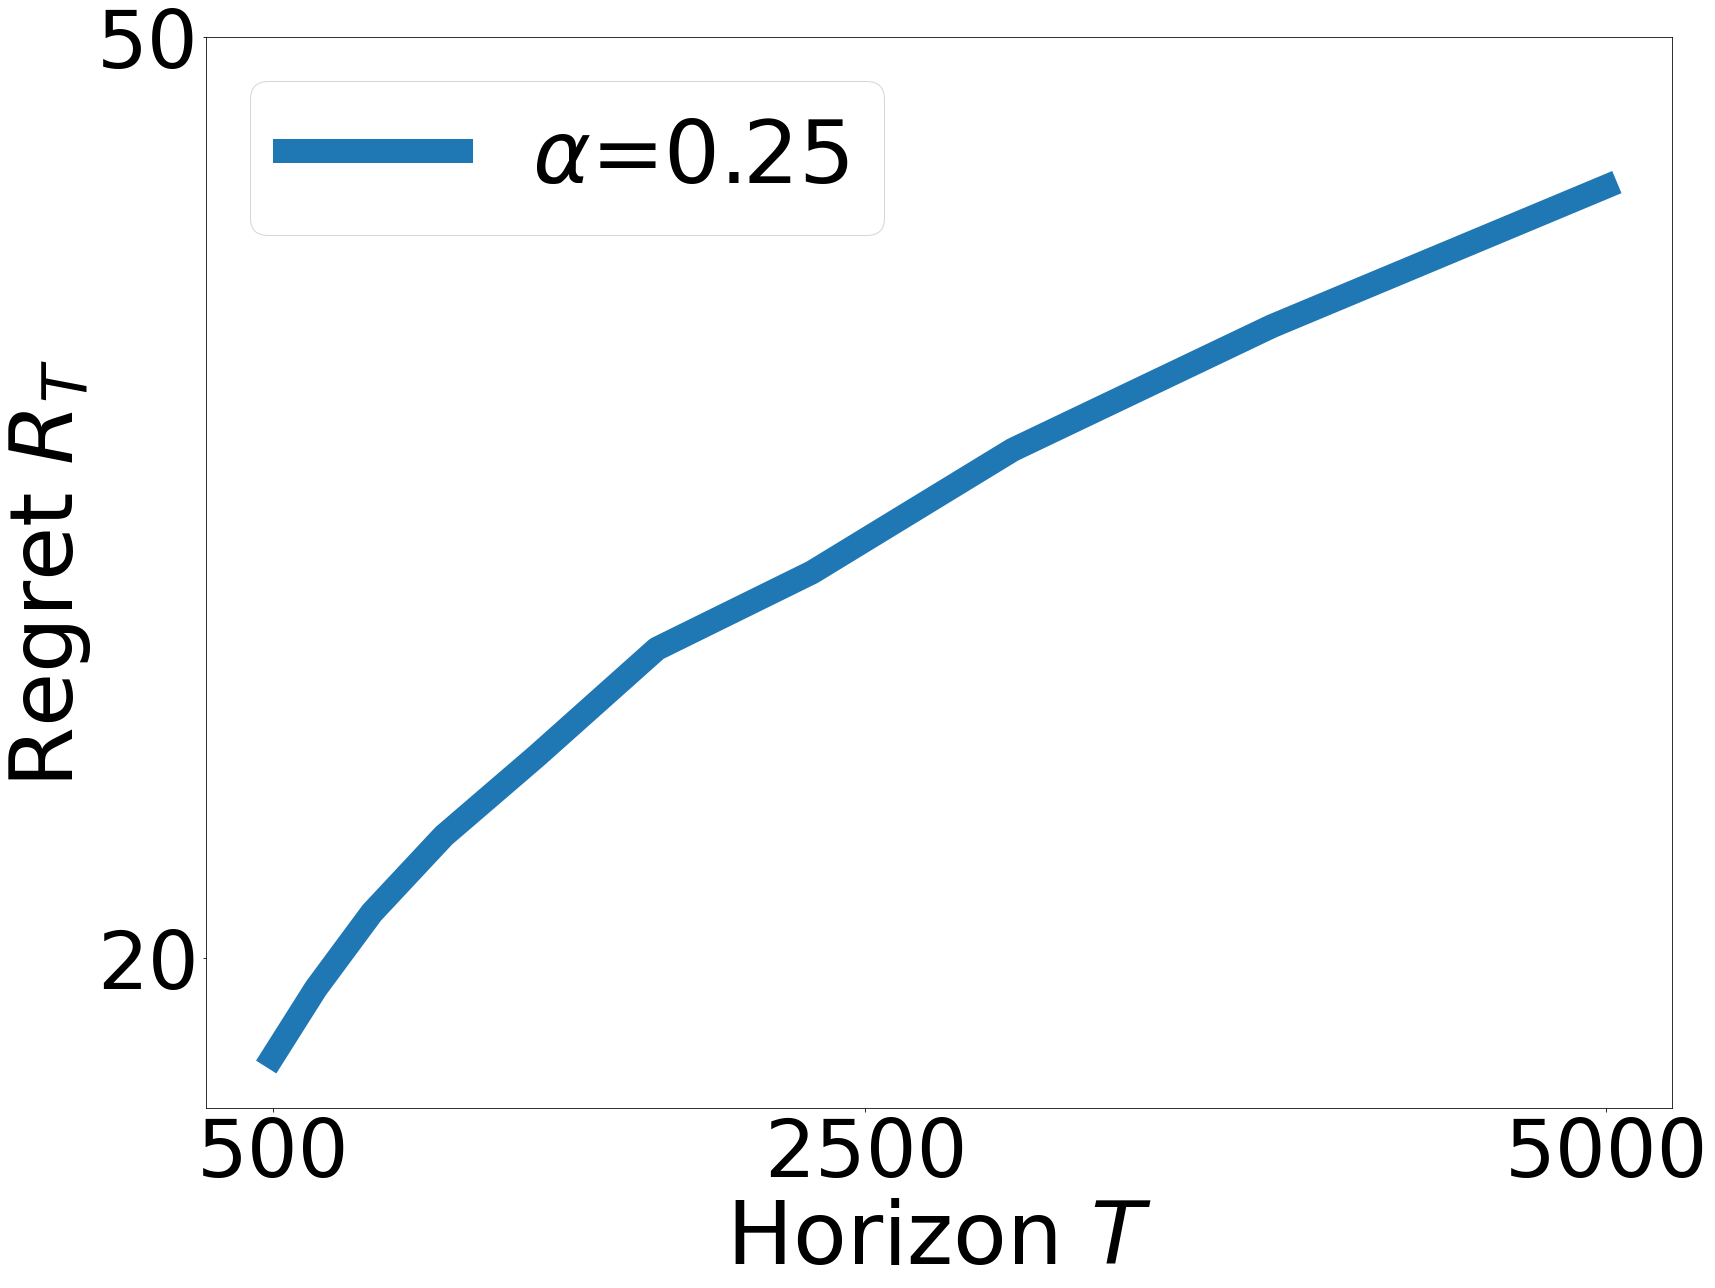

In [15]:
## generate plots for regret vs T
plotter.plot_regret(Ts, results_all)

[0.5 0. ]
(10, 250, 2)
(10, 250)
(10, 250)


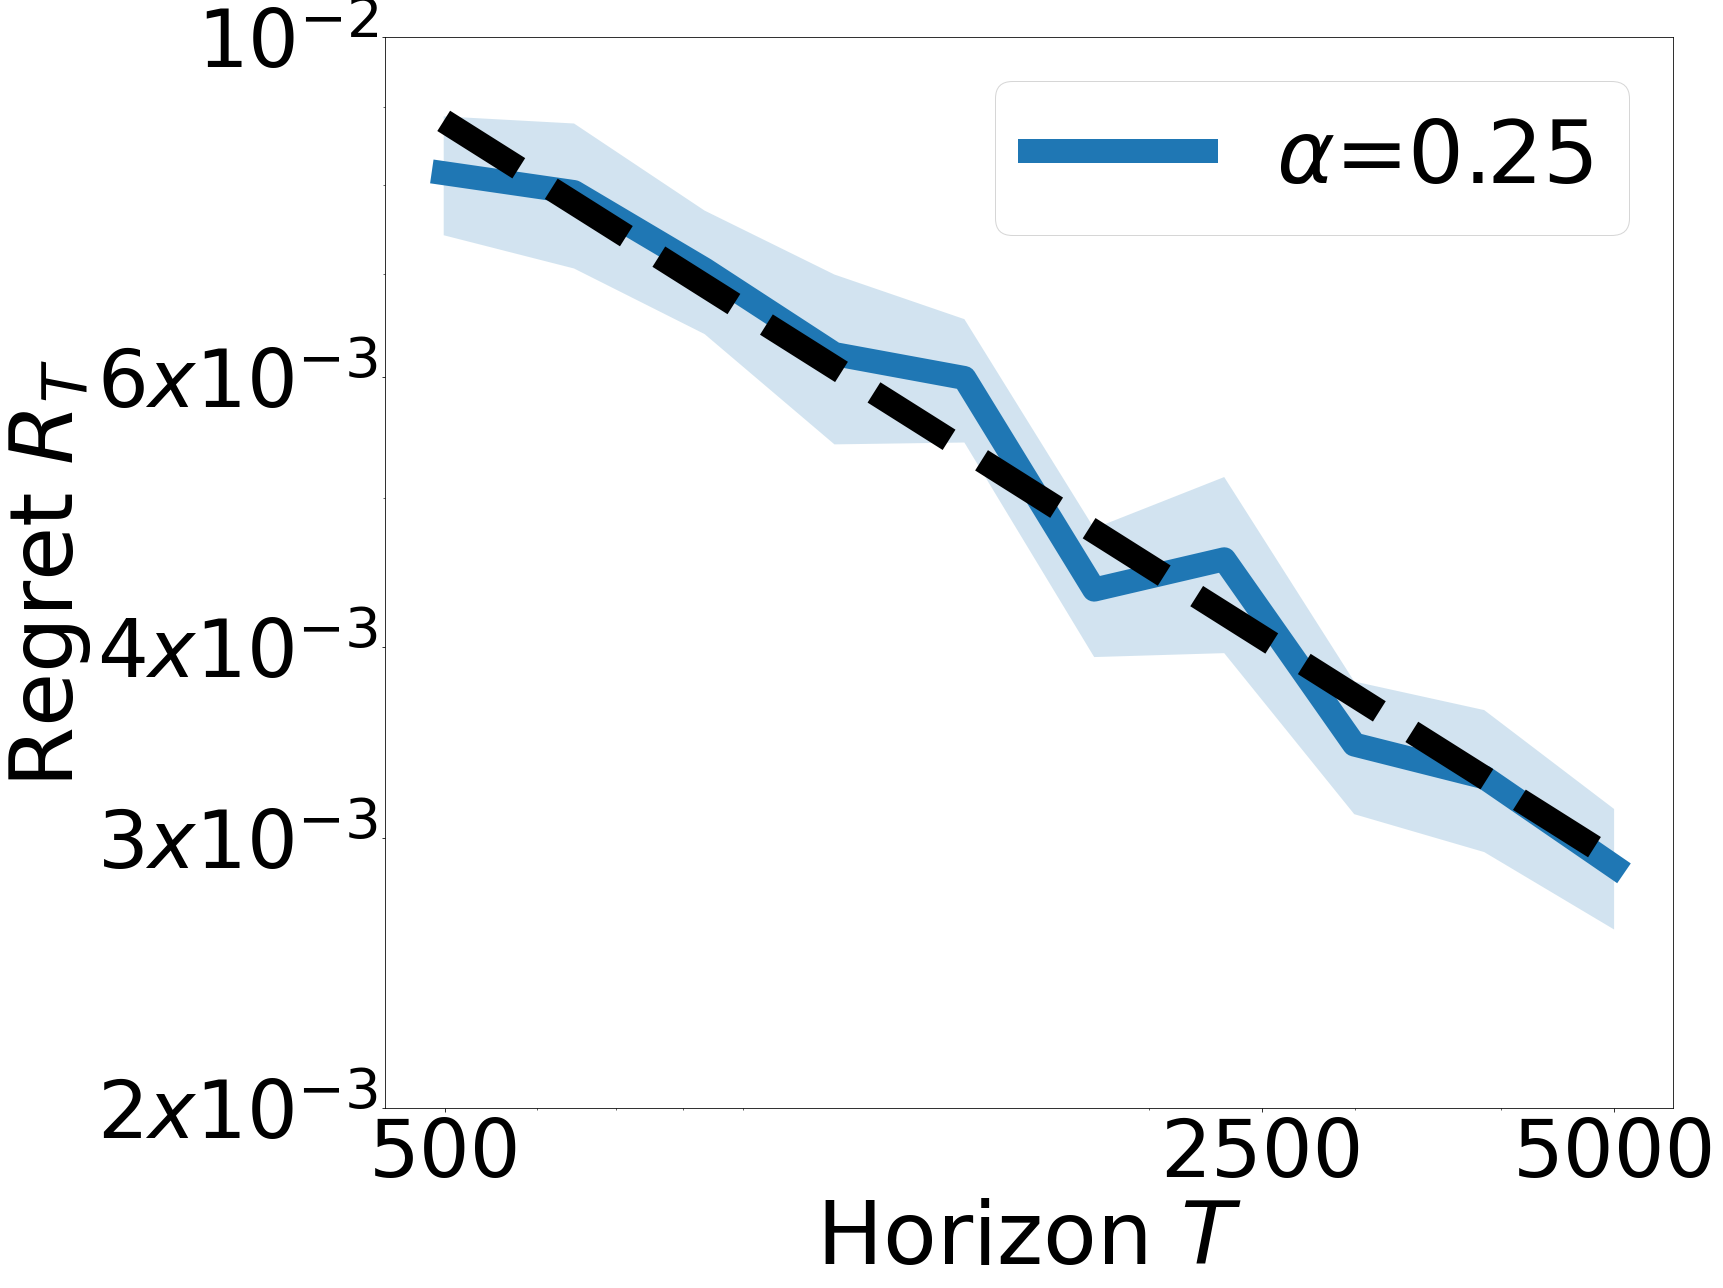

In [30]:
plotter.plot_mse(Ts, results_all, PRIOR)